# 6.2 Building maps with the Extended Kalman Filter - The Nirvana shopping mall

The managers behind the **<span style="color:seagreen">Nirvana shopping mall</span>**, in the scope of their *experiencing the future* plan, have contacted **<span style="color:seagreen">UMA-MR</span>** (our brand-new mobile robotics company at UMA) looking for mobile robots able to guide their visitors between different points of interest in their facilities, like information points, the entrance to relevant (paying well) shops, rescue points, etc. 

<br /><br />
<center>
<img src="./images/nirvana-logo.png" width="600">
</center>
<br />

These managers have placed identifying marks close to the points of interest they want to consider, but do not know their exact location in the mall. **Our mission as engineers at *UMA-MR* is to build a map of the mall containing such points, so the robot can operate within it.** We are going to use for that an **Extended Kalman Filter (EKF)**.

Fortunately, our company has developed a system able to provide the exact location of our robots at each time instant, which are also equipped with a range-and-bearing nosiy sensor able to detect the identifying marks and take measurements to them.

## 6.2.1 Formalizing the problem

Since we are going to build a map of $N$ landmarks, the position of those landmarks in the map $m$ are the random variables to be estimated. In this way, the state vector in the mapping case is defined as:

$$m = [m_1, m_2, \cdots, m_N] = 
[x_1, y_1, \underbrace{x_2, y_2}_{\text{Position of}\\\text{landmark 2}}, \dots,x_N, y_N]^T, \ \ \ len(m) = 2N$$

In other words, we pursuit the estimation of the probability distribution:

$$p(m | z_{1:t}, x_{1:t})$$

being $z_{1:t}$ the sensor measurements taken until time instant $t$, and $x_{1:t}$ the robot poses from which those measurements were acquired. Recall that a sensor measurement is related to the pose $x$ and the map $m$ by means of the **observation function**:

$$z = h(x,m) + e \, \, \, \, \, \, \, \, \, \, \, \, \, e \sim N(0,Q)$$

Two assumptions are made when building maps using EFK.

#### Assumption 1: each landmark position is estimated independently

For simplifying the problem, it is usual to assume that the estimation of the position of the landmarks is independent one to another, only depending each one on its observations, so:

$$p(m_i|z_{1:t}, x_{1:t}) = p(m_i |z^i_{1:t}, x_{1:t})$$

which results in the following simplification:

$$p(m | z_{1:t}, x_{1:t})= p(m_1, m_2, \cdots, m_N | z_{1:t}, x_{1:t}) = \prod_{k=1}^N p(m_i | z^i_{1:t}, x_{1:t})$$

As a consequence of this, the estimation of, for example, 3 landmarks simultaneously is the same as using three concurrent and independent EKFs for estimating them. 

#### Assumption 2: the map is static

Unlike the localization case, where the robot pose changed over time, in this case it is assumed that the map is static, that is, the landmarks are still. This means that in the state transition model $m_k=m_{k-1}$, that is:

$$m_t = A_t m_{t-1} + B_t u_t + \epsilon_t \ \ \ \ (A=I, u=0, \epsilon=0)$$

So good news here!, there is no need for a prediction step in the EKF, we only have to model the correction (update) one. 

## 6.2.2 Developing the EKF filter for mapping the mall

In [21]:
%matplotlib notebook

import sys
import time

import numpy as np
from numpy import random
from scipy import linalg
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from utils.tcomp import tcomp
from utils.AngleWrap import AngleWrap
from utils.DrawRobot import DrawRobot
from utils.PlotEllipse import PlotEllipse
from utils.Jacobians import J2
from utils.unit6.MapCanvas import MapCanvas

### The provided robot

Take a look at the following ``EFKMappingRobot()`` class, which is already provided by your colleagues at **<span style="color:seagreen">UMA-MR</span>**, modeling **a robot equipped with a range and bearing sensor**, which is able to keep the following information:
- ``true_pose``: The exact pose of the robot in the environment, which is perfectly known.
- ``Q``: Uncertainty of the range and bearing sensor, which has the form:
$\Sigma_{r\theta} = \begin{bmatrix} \sigma^2_r & 0 \\ 0 & \sigma^2_\theta  \end{bmatrix}$
- ``xEst``: Vector with the estimated state, in this case the position of the $M$ observed landmarks: $[x_1, y_1, x_2, y_2, \dots,x_M, y_M]^T$. Its size changes over time with the detection of previously unobserved landmarks.
- ``PEst``: uncertainty associated with those predictions, with size ($M\times2$,$M\times2$). Its size also changes over time.
- ``MappedLandmarks``: A vector with length equal to the number of landmarks in the map ($N$), which elements can take the following values:
  - ``-1`` if the landmark with that index has not been seen yet.
  - ``idx_in_xEst``: an odd number indicating the position of that landmark in ``xEst``.
  For example, if during the robot operation in a map with 5 landmarks, it first detect the landmark with id 2, and later the one with id 4, the content of this vector would be ``MappedLandmarks=[-1,-1,1,-1,3]``.

and to perform the following actions:

- ``step()``: Performs a motion command, without noise. 
- ``observe()``: Returns a range and bearing measurement (in polars) to a given landmark in the map.
- ``get_random_observation()``: Returns a range and bearing measurement (in polars) to a random landmark.

In [22]:
class EFKMappingRobot():
    def __init__(self, true_pose, sigma_r, sigma_theta, n_features):
        # Robot description
        self.true_pose = true_pose
        self.Q = np.diag([sigma_r, sigma_theta])**2
        
        # Map -- Initially empty
        self.xEst = np.empty((0, 0))
        self.PEst = np.empty((0, 0))
        self.QEst = 1.0*self.Q
        
        self.MappedLandmarks = -1*np.ones((n_features,1), int)
        
    def step(self, u):
        self.true_pose = tcomp(self.true_pose, u)
        
    def observe(self, idx, world, noisy=True):
        """ Generate a observation of a feature in our world
        
            Args:
                world: Complete map of all landmarks in the world
                idx: Landmark to observe (index in world matrix)
                noisy: Add noise to z, prorportional to self.Q
                
            Returns:
                z: One range and bearing observation
        """
        
        z = np.empty((2, 1))
        delta = world[:, [idx]] - self.true_pose[0:2, :]
        
        # Range
        z[0, :] = np.sqrt(np.sum(delta**2))
        # Bearing
        z[1, :] = np.arctan2(delta[1, 0],delta[0, 0]) - self.true_pose[2, 0]
        z[1, :] = AngleWrap(z[1, :])
        
        if noisy:
            z = z + np.sqrt(self.Q)@random.randn(2,1)
            
        return z
    
    def get_random_observation(self, world, noisy=True):
        iLandmarks = world.shape[1]
        iLandmark = random.randint(iLandmarks)
        z = self.observe(iLandmark, world, noisy)
        return z, [iLandmark]
        

### The prediction step

As commented, the map is considered static, so the prediction step is reduced to consider as the predicted landmarks' positions the ones estimated in the previous step. The same holds for the predicted uncertainty, so this steps results in something like this:

$$
  \begin{aligned}
       \verb!def !& \verb!ExtendedKalmanFilter!(m_{t-1},\Sigma_{t-1}, z_t): \\
      & \textbf{Prediction.} \\
      & \bar m_t = m_{t-1} &\text{(1. Map prediction)}\\
      & \bar\Sigma_t = \Sigma_{t-1} &\text{(2. Uncertainty of prediction)}\\      
  \end{aligned}
$$

### **<span style="color:green"><b><i>ASSIGNMENT 1: Implementing the naive prediction step</i></b></span>** 

**You are tasked to** implement the previous behavior in the following function, which performs the prediction step.

In [23]:
def prediction_step(robot: EFKMappingRobot): 
    """ Performs the prediction step of the EKF algorithm for mapping
            robot: Robot base (contains state map: xEst, PEst)
        
        Returns: Nothing. But it modifies the state in robot
            xPred: Predicted position of the landmarks
            PPred: Predicted uncertainty of the landmarks positions
    """    
    
    # We assume that the map is static 
    xPred = robot.xEst
    PPred = robot.PEst
    
    return xPred, PPred

You can **test your function** with the next code:

In [24]:
# TRY IT!
xVehicleTrue = np.vstack([0.5, 0.7, 0]) # We know the exact robot pose at any moment
robot = EFKMappingRobot(xVehicleTrue, 1, 0.8, 1)
robot.xEst = np.vstack([.5, .7])
robot.PEst = np.diag([1.32, 0.8])
[xPred,PPred] = prediction_step(robot)
print('xPred:\n' + str(xPred))
print('PPred:\n' + str(PPred))

xPred:
[[0.5]
 [0.7]]
PPred:
[[1.32 0.  ]
 [0.   0.8 ]]


<span style="color:blue">Expected output:</span>

```
xPred:
[[0.5]
 [0.7]]
PPred:
[[1.32 0.  ]
 [0.   0.8 ]]
```

### Observing a landmark for first time

When the sensor onboard the robot detects a landmark for the first time, there is no need to do the EKF update step (indeed, since there is not previously knowledge about the landmark, there is nothing to update). Instead, we have to properly modify 1) the vector of estimated landmark positions, and 2) their associated uncertainties, to accommodate this new information:


1. **Modifying the state vector**: Insert the position of the new observed landmark $[x_{M+1},y_{M+1}]$, using the sensor measurement $z_k=[r_k,\theta_k]$, at the end of the vector containing the estimated positions ``xEst``, so: $\\[10pt]$
$$xEst=[x_1,y_y, \cdots, x_M, y_M, x_{M+1}, y_{M+1}]\\[5pt]$$ 
Since the measurment is provided in polar coordinates in the robot local frame, we have to convert them first to cartensians and then to the world frame using the robot pose $[x_v,y_v]'$. The function in charge of doing so can be defined as:

$$ 
f(x_v,z_k)=\begin{bmatrix} x_{M+1} \\ y_{M+1} \end{bmatrix} =
\begin{bmatrix} x_v \\ y_v \end{bmatrix} + 
r_k\begin{bmatrix} cos \alpha_k \\ sin \alpha_k \end{bmatrix}
, \ \ \alpha_k = \theta_k + \theta_v
$$

2. **Extending the covariance matrix**. In order to acomodate the uncertainty regarding the position of the new landmark, we have to extend the covariance matrix in the following way: $\\[10pt]$
$$
PEst=\begin{bmatrix}
    [\Sigma^1_{xy}]_{2 \times 2} & \cdots & 0_{2 \times 2} \\
    \vdots & \ddots & \vdots \\
    0_{2 \times 2} & \cdots & [\Sigma^{M+1}_{xy}]_{2 \times 2}
  \end{bmatrix}_{2n \times 2n}
  $$  
Notice that the covariance $\Sigma^{M+1}_{xy}$ stands for the uncertainty in the measurement expressed in the world cartesian coordinates, retrieved by: $\\[10pt]$
$$\Sigma^{M+1}_{xy} = J \Sigma^{M+1}_{r\theta} J^T \\[5pt]$$ 
being $\Sigma^{M+1}_{r\theta}$ the uncertainty characterizing the sensor measurements (``QEst`` in our code), and $J$ (``jGz`` in our code) the jacobian of the function $f(x_v,z_k)$ that expresses the measurement in global coordinates, which is: $\\[10pt]$
$$
J =  \begin{bmatrix} \partial x / \partial r  &  \partial x / \partial \theta \\ \partial y / \partial r & \partial y / \partial \theta \end{bmatrix} =
\begin{bmatrix} cos \alpha & -r sin \alpha \\ sin \alpha & r cos \alpha \end{bmatrix} \\[10pt]
$$
Notice that this jacobian is the result of concatenating both, the jacobian of the composition of a pose and a landmark, and the jacobian of the function transforming polar into cartesian coordinates. It is quite similar to the one just transforming polar into cartesian, but in this case the angle  𝛼  is the sum of the robot orientation and the measured angle (bearing).

### **<span style="color:green"><b><i>ASSIGNMENT 2: Incorporating a landmark detected for first time</i></b></span>** 

**Your work here is to:**
- Complete the ``get_new_landmark_jacobians()`` to compute the jacobian $J$.
- Complete the ``incorporate_new_landmark()`` method to modify the state vector ``xEst`` and the convariance matrix ``PEst`` as explained above. We will make use of the [`linalg.block_diag()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.block_diag.html) function at this point.

In [25]:
def get_new_landmark_jacobians(Xv, z):
    """ Calculate the jacobian for transforming an observation to the world frame
    
        Args:
            Xv: True pose of our robot
            z: Observation of a landmark. In polar coordinates from the p.o.v. of our robot.
        
        Returns:
            2x2 matrix containing the corresponding jacobian.
    """
    r, a = z
    c, s = np.cos(a), np.sin(a)
    jGz = np.array([
        [c[0], -r[0]*s[0]],
        [s[0], r[0]*c[0]]
    ])

    return jGz

Is it working properly? **Try it!**

In [26]:
# TRY IT!
z = np.vstack([1.2,0.35])
Xv = np.vstack([2, 2.1, 0])
jGz = get_new_landmark_jacobians(Xv, z)
print('jGz:\n' + str(jGz))

jGz:
[[ 0.939 -0.411]
 [ 0.343  1.127]]


<span style="color:blue">Expected output:</span>

```
jGz:
[[ 0.93937271 -0.41147737]
 [ 0.34289781  1.12724726]]
```

In [27]:
def incorporate_new_landmark(robot: EFKMappingRobot, z, iLandmark, xPred, PPred):
    """ Incorporates the information relative to a new ladmark to our system
        robot: Robot base (contains state map: xEst, PEst)
        z: Observation of a landmark
        iLandmark: Index of z in the world map
        xPred: Predicted map
        PPred: Uncertainty of the prediction

        Returns: Nothing. But it modifies the state in robot
    """
    # This is a new feature, so add it to the map        
        
    # The observation is in the local frame of the robot, it has to
    # be translated to the global frame
   

    # Add it to the current state
    nStates = xPred.size 
        
    if nStates == 0:
        robot.xEst = xLandmark
    else:
        robot.xEst = np.vstack([robot.xEst, xLandmark]) #Each new feature two new rows

    # Compute the jacobian
    jGz = get_new_landmark_jacobians(robot.true_pose, z) #Dimension 2x2
    
    # Build a matrix M incorporating the jacobian to multiply the extendend PEst matrix by it (see below)
    if nStates != 0:
        # note we don't use jacobian w.r.t vehicle since the pose doesn’t have uncertainty
        M = np.vstack([  
                np.hstack([np.identity(nStates), np.zeros((nStates, 2))]),
                np.hstack([np.zeros((2, nStates)), jGz])
            ])
    else: 
        # First landmark observed!
        M = jGz
            
    robot.PEst = M@linalg.block_diag(robot.PEst, robot.QEst)@M.T

    #This can also be done directly PEst = [PEst,zeros(nStates,2);
                                            # zeros(2,nStates),
                                            # jGz*QEst*jGz']

    #remember this landmark as being mapped: we store its ID for the state vector
    robot.MappedLandmarks[iLandmark] = robot.xEst.size-2 #Always an odd number
                

### The correction (update) step

Once a landmark has been detected and its provided information (location and uncertainty) has been properly incorporated to our mapping system, such an information can be updated with new measurements of such a landmark. For doing so, the EKF algorithm performs the following steps:

$$
  \begin{aligned}     
      & \textbf{Correction.} \\
      & K_t = \bar\Sigma_t H^T_t (H_t \bar\Sigma_t H^T_t + Q_t)^{-1} &\text{(3. Kalman gain)}\\
      & m_t = \bar m_t + K_t (z_t - h(x_t,\bar m_t)) &\text{(4. Map estimation)}\\
      & \Sigma_t = (I - K_t H_t) \bar\Sigma_t &\text{(5. Uncertainty of estimation)}\\
      & \verb!return ! m_t, \Sigma_t
  \end{aligned}
$$

Notice that the map (landmark locations) is estimated according to the map estimation in the previous time step $t-1$, the *Kalman gain*, and the error (also called ***innovation***) between the obsevation taken by the sensor ($z_t$) and the one computed by the observation model given the robot pose and the predicted map, that is $z_t - h(x_t,\bar m_t$).

In such equations, H (``jH`` in our code) represents the jacobian of the observation model. The shape of such a jacobian is $(2,M\times2)$, and has the following form:

$$
H = \left[
  \begin{matrix}
0 & 0 & \cdots \\
0 & 0 & \cdots \\
\end{matrix}
\right .
\underbrace{\begin{bmatrix}
jHxl_{11} & jHxl_{12} \\
jHxl_{21} & jHxl_{22} \\
\end{bmatrix}}_\text{Jacobian for the observed landmark, $jHxl$}
\left .
\begin{matrix}
\cdots & 0 & 0 \\
\cdots & 0 & 0 \\
\end{matrix}
\right]
$$

$$
jHxl = 
\begin{bmatrix}
(x_l - x)/d & (y_l - y)/d \\
-(y_l - y)/d^2 & (x_l - x)/d^2 \\
\end{bmatrix}
$$

where $[x_l,y_l]$ is the position of the landmark, $[x,y]$ is the robot location, and $d=\sqrt{(x_l-x)^2 + (y_l-y)^2}$.

### **<span style="color:green"><b><i>ASSIGNMENT 3: Updating the knowledge about an observed landmark</i></b></span>** 

**Your job at this point is:**

- To implement the function ``get_observation_jacobian()`` returning the jacobian of the observed landmark, that is, $jHxl$.
- To complete the ``update_step()`` method that performs the update step of the EKF algorithm.

In [28]:
def get_observation_jacobian(xPred, xLandmark):
    """ Calculate the jacobian of the observation model.
        
        Needed to update a landmark we have already seen.
        Hint. Similar to the one described in unit 5 (Localization)
        
        Args:
            xPred: True pose of our robot.
            xLandmark: Estimated pose of a landmark in our map. World p.o.v in cartesian coordinates.
                Does not contain an angle.
        
        Return:
            jHxl: 2x2 matrix containing the corresponding jacobian.
    """
    xdist = xLandmark[0]-xPred[0]
    ydist = xLandmark[1]-xPred[1]
    r = np.sqrt(np.power(xdist,2)+np.power(ydist,2))
    r2 = r**2
    jHxl = np.array([
        [xdist[0]/r[0] , ydist[0]/r[0]],
        [-ydist[0]/np.power(r[0],2) , -xdist[0]/np.power(r[0],2)]
    ])
    return jHxl


Let's see if your implementation is right:

In [29]:
# TRY IT!
xLandmark = np.vstack([2.5,2])
xPred = np.vstack([2, 2.1, 0])
jHxl = get_observation_jacobian(xPred, xLandmark)
print('jHxl:\n' + str(jHxl))

jHxl:
[[ 0.981 -0.196]
 [ 0.385 -1.923]]


<span style="color:blue">Expected output:</span>

```
jHxl:
[[ 0.98058068 -0.19611614]
 [ 0.38461538  1.92307692]]
```

In [30]:
def update_step(robot, z, iLandmark, xPred, PPred):
    """ Performs the update step of EKF
        robot: Robot base (contains state map: xEst, PEst)
        z: Observation of a landmark
        iLandmark: Index of z in the world map
        xPred: Predicted map
        PPred: Uncertainty of the prediction
        
        Returns: Nothing. But it modifies the state in robot
    """
    # Find out where it is in state vector
    landmarkIndex = robot.MappedLandmarks[iLandmark[0], 0]
        
    # xLandmark is the current estimation of the position of the
    # landmard "FeatureIndex"
    xLandmark = xPred[landmarkIndex:landmarkIndex+2]
        
    # DONE Predicts the observation
    zPred = robot.observe(0, xLandmark, noisy=False) # Hint: use robot.observe function

    # Get observation Jacobians
    jHxf = get_observation_jacobian(robot.true_pose, xLandmark)
        
    # Fill in state jacobian
    # (the jacobian is zero except for the observed landmark)
    jH = np.zeros((2, xPred.size))
    jH[:, landmarkIndex:landmarkIndex+2] = jHxf
        
    #
    # Kalman update
    #
    Innov = z-zPred # Innovation
    Innov[1] = AngleWrap(Innov[1])
    S = jH@PPred@jH.T + robot.QEst
    K = PPred@jH.T@linalg.inv(S) # Gain
    robot.xEst = xPred + K@Innov    
    robot.PEst = (np.eye(robot.PEst.shape[0]) - K@jH)@PPred
    #robot.PEst = PPred - K@S@K.T # Alternative way
    
    #ensure P remains symmetric
    robot.PEst = 0.5*(robot.PEst+robot.PEst.T)
    

### **<span style="color:green"><b><i>ASSIGNMENT 4: Putting all together in the EKF algorithm</i></b></span>** 

Now that you have implemented the building blocks of the EKF filter for mapping the **<span style="color:seagreen">Nirvana shopping mall</span>**, it is time to write a simple function ``EKFMapping()`` putting them together. For that, **you have to** call each method with the appropriate parameters.

In [31]:
def EKFMapping(robot: EFKMappingRobot, z, iLandmark):
    """ EFK algorithm for mapping
        
            robot: Robot base (contains state map: xEst, PEst)
            z: Observation of a landmark
            iLandmark: Index of z in the world map
    
        Returns: Nothing. But it modifies the state in robot
    """
    
    # Do prediction step
    [xPred, PPred] = prediction_step(robot)
    

    # Check if feature observed is in map
    if robot.MappedLandmarks[iLandmark] > -1:
        update_step(robot, z, iLandmark, xPred, PPred)
        
    else:
        # This is a new feature, so add its information to the map        
        incorporate_new_landmark(robot, z, iLandmark, xPred, PPred)

## 6.2.3 Testing the mapping system

### Playing with one landmark

Let's consider that the mall has only one landmark to get things started (``nLandmarks=1``). The following function provides a demo where the robot is commanded to follow a squared trajectory while observing a landmark after each movement. 

The **<span style="color:seagreen">Nirvana</span>** managers are curious about the state and dimensions of the variables storing the estimated positions `xEst` and their associated uncertainties `Pest`, so we show their content after each 5 iterations of the algorithm. 

<figure style="text-align:center">
  <img src="images/fig6-1-2.png" width="500" alt="">
  <figcaption>
      Fig. 1: Example run of the EKF algorithmn for mapping (only one landmark). <br/>
      it shows the true pose (in red), <br/>
      the real pose of the landmark (as a green star), <br/>
      and the estimation from the EKF algorithm (pose and confidence ellipse).
  </figcaption>
</figure>

In [32]:
def demo_ekf_mapping(robot,
                     Map,
                     nLandmarks,
                     mode='non_stop',
                     logger=None,
                     nSteps=100, # Number of motions
                     turning= 40, # Number of motions before turning (square path)
                     print_each=2):
    
    %matplotlib notebook
    if mode == 'step_by_step':
        matplotlib.use('TkAgg')

    # storing the number of times a landmark has been seen
    # also store the handler to the graphical info shown
    canvas = MapCanvas(nLandmarks)
    
    canvas.ax.plot(Map[0, :], Map[1, :], 'g*')
    hObsLine = canvas.ax.plot([0,0], [0,0], linestyle=':')
    
    # Control action
    u = np.zeros((3, 1))
    u[0] = (2.*MapSize/1.5)/turning
    u[1] = 0.
    
    # Start the loop!
    for k in range(nSteps):
        #
        # Move the robot
        #
        u[2]=0.
        if k%turning == turning-1:
            u[2] = np.pi/2
        
        robot.step(u) # Perfectly known robot pose
        
        z, iLandmark = robot.get_random_observation(world=Map)
        
        # Update the "observedtimes" for the feature and plot the reading
        canvas.increment_observed_times(iLandmark)
        canvas.PlotNumberOfReadings(robot.true_pose, iLandmark, Map)
        
        EKFMapping(robot, z, iLandmark)
        
        # Print map evolution each 5 steps
        if not k%5:
            with np.printoptions(precision=3):
                print('Iteration: ' + str(k))
                print('Estimated xEst:\n' + str(robot.xEst))
                print('Estimated PEst:\n' + str(robot.PEst))
                print('---------------------------------')
        
        # Log important values
        if logger is not None:
            logger.log(k, robot, Map)
        
        # Drawings
        if k%print_each == print_each-1:
            DrawRobot(canvas.fig, canvas.ax,robot.true_pose, 'r')#plot(xVehicleTrue(1),xVehicleTrue(2),'r*')
            canvas.DoMapGraphics(robot) # Draw estimated poitns (in black) and ellipses
            plt.axis([-MapSize-5, MapSize+5, -MapSize-5, MapSize+5]) # Set limits again
            plt.draw()
            
            if mode == 'step_by_step':
                plt.waitforbuttonpress(-1)
            elif mode == 'visualize_process':
                plt.pause(0.2)
            elif mode == 'non_stop':
                pass # non stop!

    # Final drawings
    %matplotlib inline
    if logger is not None:
        logger.plot()

<IPython.core.display.Javascript object>


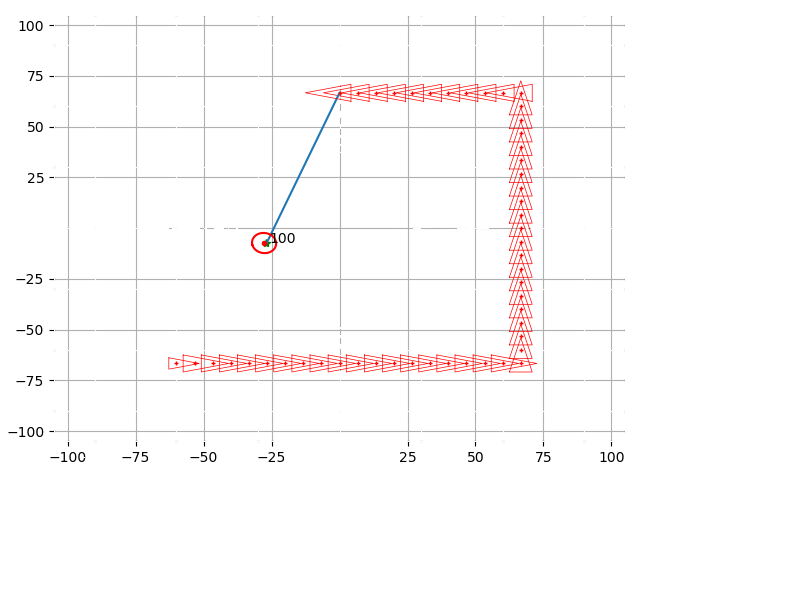

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 0
Estimated xEst:
[[2.5]
 [2. ]]
Estimated PEst:
[[60.983  1.836]
 [ 1.836 62.883]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 5
Estimated xEst:
[[-26.453]
 [-11.937]]
Estimated PEst:
[[ 26.116 -18.9  ]
 [-18.9    25.371]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 10
Estimated xEst:
[[-29.961]
 [ -6.204]]
Estimated PEst:
[[ 8.692 -4.467]
 [-4.467  8.402]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 15
Estimated xEst:
[[-28.576]
 [ -6.494]]
Estimated PEst:
[[ 4.721 -1.227]
 [-1.227  4.458]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 20
Estimated xEst:
[[-28.378]
 [ -6.84 ]]
Estimated PEst:
[[ 3.435 -0.153]
 [-0.153  3.161]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 25
Estimated xEst:
[[-28.25 ]
 [ -7.051]]
Estimated PEst:
[[2.899 0.338]
 [0.338 2.635]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 30
Estimated xEst:
[[-28.666]
 [ -6.583]]
Estimated PEst:
[[2.607 0.601]
 [0.601 2.395]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 35
Estimated xEst:
[[-29.301]
 [ -6.154]]
Estimated PEst:
[[2.395 0.75 ]
 [0.75  2.274]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 40
Estimated xEst:
[[-29.163]
 [ -6.125]]
Estimated PEst:
[[2.213 0.833]
 [0.833 2.205]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 45
Estimated xEst:
[[-28.848]
 [ -6.516]]
Estimated PEst:
[[2.03  0.862]
 [0.862 2.145]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 50
Estimated xEst:
[[-27.894]
 [ -6.666]]
Estimated PEst:
[[1.832 0.829]
 [0.829 2.063]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 55
Estimated xEst:
[[-28.257]
 [ -7.507]]
Estimated PEst:
[[1.624 0.738]
 [0.738 1.944]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 60
Estimated xEst:
[[-27.745]
 [ -7.373]]
Estimated PEst:
[[1.422 0.608]
 [0.608 1.797]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 65
Estimated xEst:
[[-28.212]
 [ -7.665]]
Estimated PEst:
[[1.248 0.47 ]
 [0.47  1.647]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 70
Estimated xEst:
[[-27.787]
 [ -7.267]]
Estimated PEst:
[[1.111 0.345]
 [0.345 1.511]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 75
Estimated xEst:
[[-27.87 ]
 [ -7.466]]
Estimated PEst:
[[1.01  0.241]
 [0.241 1.395]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 80
Estimated xEst:
[[-27.356]
 [ -6.882]]
Estimated PEst:
[[0.937 0.157]
 [0.157 1.296]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 85
Estimated xEst:
[[-27.711]
 [ -7.314]]
Estimated PEst:
[[0.882 0.087]
 [0.087 1.206]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 90
Estimated xEst:
[[-27.287]
 [ -6.705]]
Estimated PEst:
[[0.84  0.029]
 [0.029 1.123]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 95
Estimated xEst:
[[-27.609]
 [ -7.452]]
Estimated PEst:
[[ 0.808 -0.017]
 [-0.017  1.046]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [33]:
#mode = 'step_by_step'
#mode = 'visualize_process'
mode = 'non_stop'

# WORLD MAP
# Num features/landmarks considered within the map
nLandmarks = 1
# Generation of the map
MapSize = 100
Map = MapSize*random.rand(2,nLandmarks)-MapSize/2

# ROBOT
# Covariances for our very bad&expensive sensor (in the system <d,theta>)
Sigma_r = 8.0
Sigma_theta = 8*np.pi/180
# Initial robot pose
xVehicleTrue = np.vstack([-MapSize/1.5, -MapSize/1.5, 0.]) # We know the exact robot pose at any moment

robot = EFKMappingRobot(xVehicleTrue, Sigma_r, Sigma_theta, nLandmarks)

demo_ekf_mapping(robot, Map ,nLandmarks, mode=mode)

### Considering a larger number of landmarks 

Once our EKF implementation is working with one landmark, let's try it in a scenario with 5 landmarks. Again, the content of the `xEst` and `Pest` is shown after each 5 iterations of the algorithm.
    
<figure style="text-align:center">
  <img src="images/fig6-1-3.png" width="500" alt="">
  <figcaption>
      Fig. 2: Execution of the EKF algorithmn for mapping (multiple landmarks). <br/>
      Same as in Fig 1., each landmark is accompanied by a number of times observed.
  </figcaption>
</figure>



<IPython.core.display.Javascript object>


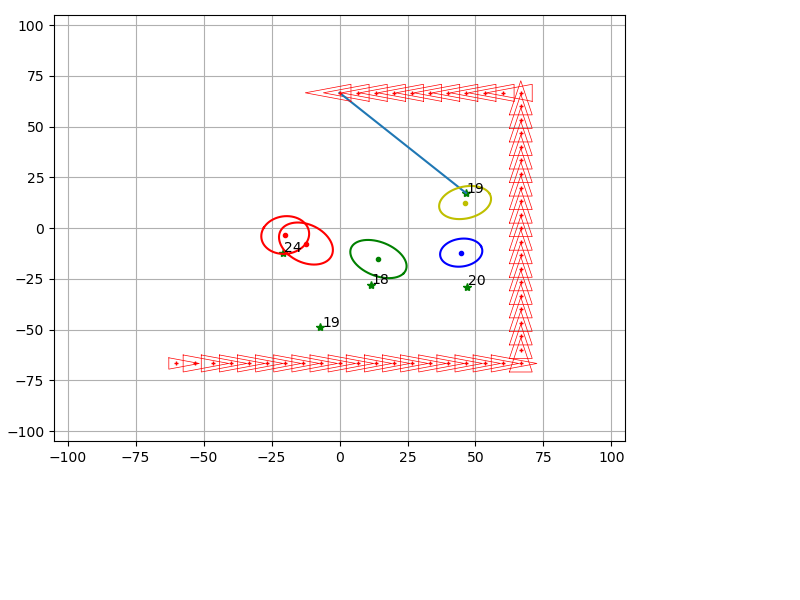

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 0
Estimated xEst:
[[2.5]
 [2. ]]
Estimated PEst:
[[59.537  9.876]
 [ 9.876 42.145]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 5
Estimated xEst:
[[-0.076]
 [-6.66 ]
 [11.89 ]
 [16.473]
 [ 2.5  ]
 [ 2.   ]]
Estimated PEst:
[[ 30.508 -12.1     0.      0.      0.      0.   ]
 [-12.1    24.895   0.      0.      0.      0.   ]
 [  0.      0.     84.148 -68.541   0.      0.   ]
 [  0.      0.    -68.541 106.113   0.      0.   ]
 [  0.      0.      0.      0.    148.16  -67.244]
 [  0.      0.      0.      0.    -67.244 117.728]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 10
Estimated xEst:
[[-0.076]
 [-6.66 ]
 [37.005]
 [-3.534]
 [15.811]
 [22.59 ]
 [17.054]
 [-8.164]]
Estimated PEst:
[[ 30.508 -12.1     0.      0.      0.      0.      0.      0.   ]
 [-12.1    24.895   0.      0.      0.      0.      0.      0.   ]
 [  0.      0.     66.194 -49.936   0.      0.      0.      0.   ]
 [  0.      0.    -49.936  67.157   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.    101.48  -66.547   0.      0.   ]
 [  0.      0.      0.      0.    -66.547  82.688   0.      0.   ]
 [  0.      0.      0.      0.      0.      0.     40.584 -24.252]
 [  0.      0.      0.      0.      0.      0.    -24.252  38.396]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 15
Estimated xEst:
[[ 11.674]
 [-16.702]
 [ 44.083]
 [ -6.55 ]
 [ 22.567]
 [ 25.583]
 [ 17.054]
 [ -8.164]]
Estimated PEst:
[[ 24.272 -11.615   0.      0.      0.      0.      0.      0.   ]
 [-11.615  20.855   0.      0.      0.      0.      0.      0.   ]
 [  0.      0.     61.767 -52.115   0.      0.      0.      0.   ]
 [  0.      0.    -52.115  60.602   0.      0.      0.      0.   ]
 [  0.      0.      0.      0.     56.458 -33.529   0.      0.   ]
 [  0.      0.      0.      0.    -33.529  38.298   0.      0.   ]
 [  0.      0.      0.      0.      0.      0.     40.584 -24.252]
 [  0.      0.      0.      0.      0.      0.    -24.252  38.396]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 20
Estimated xEst:
[[ 11.674]
 [-16.702]
 [ 45.262]
 [-10.965]
 [ 33.393]
 [ 23.642]
 [ 24.328]
 [-18.506]
 [  2.5  ]
 [  2.   ]]
Estimated PEst:
[[ 24.272 -11.615   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [-11.615  20.855   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     59.948 -51.831   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -51.831  58.372   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     37.597 -21.277   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -21.277  24.007   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     26.791 -15.822   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -15.822  26.69    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     52.22
   -3.839]
 [  0.      0.      0.      0.      0.      0.      0.      0.     -3.839
   62.749]]
-----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 25
Estimated xEst:
[[ -2.584]
 [-14.417]
 [ 45.262]
 [-10.965]
 [ 33.393]
 [ 23.642]
 [ 24.328]
 [-18.506]
 [-12.252]
 [ -2.055]]
Estimated PEst:
[[ 13.592  -4.543   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -4.543  13.848   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     59.948 -51.831   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -51.831  58.372   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     37.597 -21.277   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -21.277  24.007   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     26.791 -15.822   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -15.822  26.69    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     15.704
    5.758]
 [  0.      0.      0.      0.      0.      0.      0.      0.      5.758
   15.   ]]
----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 30
Estimated xEst:
[[ -4.285]
 [-15.844]
 [ 56.358]
 [-22.793]
 [ 33.393]
 [ 23.642]
 [ 24.328]
 [-18.506]
 [-15.389]
 [ -3.097]]
Estimated PEst:
[[ 10.182  -1.272   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -1.272  10.436   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     25.562 -19.792   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -19.792  26.497   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     37.597 -21.277   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -21.277  24.007   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     26.791 -15.822   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -15.822  26.69    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     12.946
    7.004]
 [  0.      0.      0.      0.      0.      0.      0.      0.      7.004
   12.069]]
----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 35
Estimated xEst:
[[ -4.285]
 [-15.844]
 [ 49.141]
 [-19.067]
 [ 41.853]
 [ 15.898]
 [ 20.863]
 [-18.973]
 [-15.929]
 [ -2.559]]
Estimated PEst:
[[ 10.182  -1.272   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -1.272  10.436   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      9.899  -6.501   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     -6.501  12.458   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     23.373 -10.181   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -10.181  14.542   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     13.128  -3.846   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     -3.846  14.59    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     12.579
    7.324]
 [  0.      0.      0.      0.      0.      0.      0.      0.      7.324
   11.788]]
----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 40
Estimated xEst:
[[ -4.285]
 [-15.844]
 [ 49.63 ]
 [-20.737]
 [ 45.142]
 [ 13.376]
 [ 21.267]
 [-19.85 ]
 [-15.929]
 [ -2.559]]
Estimated PEst:
[[10.182 -1.272  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-1.272 10.436  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.356 -2.043  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -2.043  7.223  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    13.343 -3.087  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -3.087  8.446  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    10.099 -0.609  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.609 11.062  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    12.579  7.324]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     7.324 11.788]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 45
Estimated xEst:
[[ -5.044]
 [-13.338]
 [ 48.933]
 [-21.116]
 [ 44.856]
 [ 14.376]
 [ 21.267]
 [-19.85 ]
 [-17.016]
 [ -1.894]]
Estimated PEst:
[[ 8.757 -0.113  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.113  9.189  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     4.286 -0.988  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.988  5.971  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     9.185 -0.737  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.737  6.298  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    10.099 -0.609  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.609 11.062  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    11.742  7.183]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     7.183 11.419]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 50
Estimated xEst:
[[ -5.314]
 [-10.092]
 [ 46.043]
 [-14.083]
 [ 44.856]
 [ 14.376]
 [ 19.215]
 [-18.98 ]
 [-15.968]
 [ -1.049]]
Estimated PEst:
[[ 7.746  0.426  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.426  8.288  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     3.503  0.384  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.384  3.233  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     9.185 -0.737  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.737  6.298  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     8.641  0.503  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.503  8.403  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    10.223  6.694]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     6.694 10.604]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 55
Estimated xEst:
[[ -5.869]
 [ -7.356]
 [ 44.087]
 [-10.121]
 [ 45.07 ]
 [ 14.106]
 [ 19.215]
 [-18.98 ]
 [-16.462]
 [ -0.223]]
Estimated PEst:
[[6.915 0.41  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.41  7.492 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    3.273 0.686 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.686 2.496 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    7.025 0.48  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.48  5.497 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    8.641 0.503 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.503 8.403 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    8.246 5.355]
 [0.    0.    0.    0.    0.    0.    0.    0.    5.355 9.032]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 60
Estimated xEst:
[[ -6.479]
 [ -4.723]
 [ 44.087]
 [-10.121]
 [ 45.07 ]
 [ 14.106]
 [ 15.808]
 [-14.654]
 [-16.462]
 [ -0.223]]
Estimated PEst:
[[ 6.244  0.382  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.382  6.843  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     3.273  0.686  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.686  2.496  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     7.025  0.48   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.48   5.497  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     5.73  -1.083  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.083  4.797  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     8.246  5.355]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.355  9.032]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 65
Estimated xEst:
[[ -6.806]
 [ -2.564]
 [ 45.389]
 [ -9.357]
 [ 45.686]
 [ 11.282]
 [ 15.051]
 [-13.511]
 [-16.462]
 [ -0.223]]
Estimated PEst:
[[ 5.682  0.059  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.059  6.31   0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.838  0.37   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.37   2.26   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     6.25   1.186  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.186  3.565  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     5.095 -1.395  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.395  4.276  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     8.246  5.355]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.355  9.032]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 70
Estimated xEst:
[[-10.521]
 [ -0.961]
 [ 45.389]
 [ -9.357]
 [ 45.686]
 [ 11.282]
 [ 15.051]
 [-13.511]
 [-15.952]
 [  1.51 ]]
Estimated PEst:
[[ 4.624 -0.648  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.648  5.316  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.838  0.37   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.37   2.26   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     6.25   1.186  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.186  3.565  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     5.095 -1.395  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.395  4.276  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.735  2.949]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     2.949  6.546]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 75
Estimated xEst:
[[-11.368]
 [ -0.657]
 [ 45.08 ]
 [-10.369]
 [ 45.686]
 [ 11.282]
 [ 14.625]
 [-14.395]
 [-16.899]
 [  0.619]]
Estimated PEst:
[[ 4.398 -0.805  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.805  5.106  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.677  0.272  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.272  2.163  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     6.25   1.186  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.186  3.565  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.816 -1.612  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.612  4.068  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.009  2.232]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     2.232  5.797]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 80
Estimated xEst:
[[-11.368]
 [ -0.657]
 [ 45.08 ]
 [-10.369]
 [ 45.483]
 [ 10.969]
 [ 14.717]
 [-14.623]
 [-20.361]
 [ -2.688]]
Estimated PEst:
[[ 4.398 -0.805  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.805  5.106  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.677  0.272  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.272  2.163  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     5.33   0.716  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.716  3.257  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.711 -1.691  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.691  3.979  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.835  0.993]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.993  4.473]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 85
Estimated xEst:
[[-12.374]
 [ -2.376]
 [ 44.628]
 [-11.699]
 [ 46.197]
 [ 12.013]
 [ 14.717]
 [-14.623]
 [-20.601]
 [ -2.875]]
Estimated PEst:
[[ 4.264 -0.972  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.972  4.889  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.52   0.217  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.217  2.021  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     4.76   0.509  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.509  3.065  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.711 -1.691  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.691  3.979  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.6    0.739]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.739  4.196]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 90
Estimated xEst:
[[-12.781]
 [ -5.738]
 [ 44.628]
 [-11.699]
 [ 45.948]
 [ 12.419]
 [ 14.717]
 [-14.623]
 [-20.947]
 [ -3.342]]
Estimated PEst:
[[ 4.048 -1.206  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-1.206  4.5    0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.52   0.217  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.217  2.021  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.977  0.499  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.499  2.812  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.711 -1.691  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.691  3.979  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.407  0.511]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.511  3.924]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 95
Estimated xEst:
[[-12.359]
 [ -7.586]
 [ 44.833]
 [-11.837]
 [ 46.009]
 [ 12.678]
 [ 14.309]
 [-15.223]
 [-20.947]
 [ -3.342]]
Estimated PEst:
[[ 3.931 -1.246  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-1.246  4.294  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     2.459  0.232  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.232  1.965  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.786  0.598  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.598  2.728  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.289 -1.452  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.452  3.543  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.407  0.511]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.511  3.924]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [35]:
#mode = 'step_by_step'
mode = 'visualize_process'
#mode = 'non_stop'

# WORLD MAP
# Num features/landmarks considered within the map
nLandmarks = 5
# Generation of the map
MapSize = 100
Map = MapSize*random.rand(2,nLandmarks)-MapSize/2

# ROBOT
# Covariances for our very bad&expensive sensor (in the system <d,theta>)
Sigma_r = 8.0
Sigma_theta = 7*np.pi/180
# Initial robot pose
xVehicleTrue = np.vstack([-MapSize/1.5, -MapSize/1.5, 0.]) # We know the exact robot pose at any moment

robot = EFKMappingRobot(xVehicleTrue, Sigma_r, Sigma_theta, nLandmarks)

demo_ekf_mapping(robot, Map ,nLandmarks, mode=mode)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Having completed these trials, you will be able to **answer the following questions**:

In the **one landmark** case:

- Discuss the evolution of the variables `xEst` and `Pest`, including their dimensions.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>XEst es de dimensiones 2x1 y PEst es de dimensiones 2x2.
    La variable XEst se aproxima rapidamente a su valor real y mientras mas observaciones de la landmark tengamos, más pequeña será la variable PEst.</i></p>
    
In the **five landmarks** case:

- Why and how the content of the variables `xEst` and `Pest` has change? Discuss their size.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Como solo observamos una landmark, a cada observación la incertidumbew disminuye aún más.</i></p>

- What structure does the matrix of covariances have? Is there any kind of correlation among the observations of different landmarks?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Tiene el tamaño 2x(nº landmarks x nº landmarks). Su diagonal son bloques 2x2 y el resto de la matriz son ceros.</i></p>

### Getting performance results

As is normal, the contracting company requires some information about how well our EFK implementation performs. For that, your colleagues have implemented a logger, which is meant to store some information each loop regarding the method performance and plot it at the end of its execution. **Execute the following code cells and take a look at that plots!**

In [19]:
import pandas as pd

class Logger():
    """ Logs info about the covariance and error of a map.
    
        Attrs:
            n_features: Number of features in the world.
            log_error: Matrix to store the error in the fitting for each landmark.
            log_det: Matrix to store the determinant of the covariance matrix for each landmark.
    
    """
    def __init__(self, n_steps, n_features):
        """ Initializes each matrix to log the information
        
            Args:
                n_steps: Maximum number of steps our robot will take.
                n_features: Number of features in the world.
        """
        self.n_features = n_features
        self.log_error = np.empty((n_steps,n_features))
        self.log_det = np.empty((n_steps,n_features))
            
    def log(self, k: int, robot: EFKMappingRobot, Map: np.ndarray):
        """ Computes relevant info about the error and covariances.
        
            It is called once per loop in the demo.
        
            Args:
                k: Number of iteration we are at. Range: [0, n_steps)
                robot: 
                Map:
        """
        for idx in range(self.n_features):
            tid = robot.MappedLandmarks[idx,0]
            if tid <= -1:
                self.log_error[k,idx]= np.Inf
                self.log_det[k,idx]=np.Inf
            else:
                self.log_det[k,idx] = np.linalg.det(robot.PEst[tid:tid+2,tid:tid+2])
                self.log_error[k,idx] = np.sqrt(np.sum((robot.xEst[tid:tid+2,0] - Map[:,idx])**2))
                
    def plot(self):
        """ Plot all relevant figures. It is called at the end of the demo"""
        fig1 , ax1 =plt.subplots(1, 1, sharex=True)
        fig2 , ax2 =plt.subplots(1, 1, sharex=True)
        fig2.tight_layout()
        fig1.tight_layout()

        df1 = pd.DataFrame(data= self.log_error, columns = ['Landmark {}'.format(i) for i in range(self.n_features)])
        ax1.set_title('Error between map and est')
        df1.plot(ax = ax1)
        df2 = pd.DataFrame(data=np.log(self.log_det), columns=['Landmark {}'.format(i) for i in range(self.n_features)])
        ax2.set_title('Det. of covar.')
        df2.plot(ax = ax2)

<IPython.core.display.Javascript object>


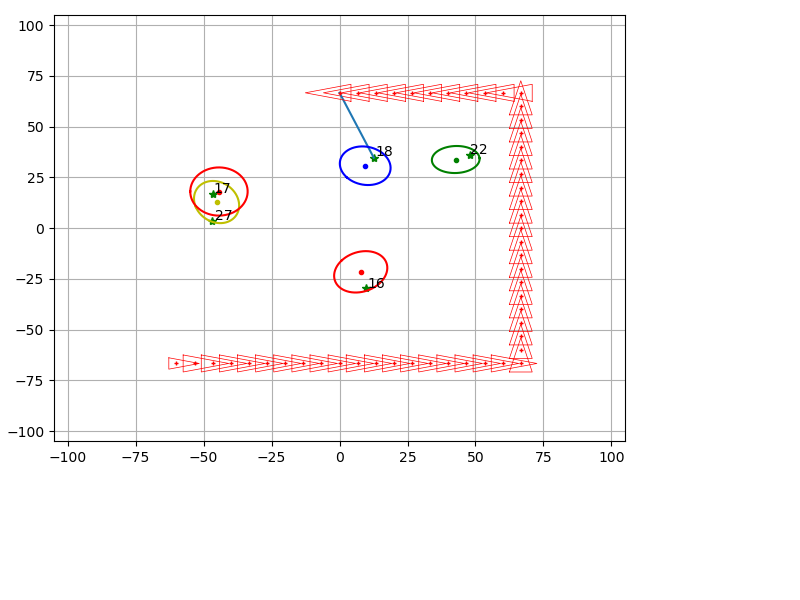

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 0
Estimated xEst:
[[2.5]
 [2. ]]
Estimated PEst:
[[67.611 -5.301]
 [-5.301 71.783]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 5
Estimated xEst:
[[ 2.5  ]
 [ 2.   ]
 [ 9.003]
 [10.897]
 [ 2.5  ]
 [ 2.   ]
 [ 2.5  ]
 [ 2.   ]
 [ 2.5  ]
 [ 2.   ]]
Estimated PEst:
[[  67.611   -5.301    0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [  -5.301   71.783    0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [   0.       0.     134.129  -94.668    0.       0.       0.       0.
     0.       0.   ]
 [   0.       0.     -94.668  107.413    0.       0.       0.       0.
     0.       0.   ]
 [   0.       0.       0.       0.      71.841   -1.52     0.       0.
     0.       0.   ]
 [   0.       0.       0.       0.      -1.52    64.295    0.       0.
     0.       0.   ]
 [   0.       0.       0.       0.       0.       0.     173.464 -116.078
     0.       0.   ]
 [   0.       0.       0.       0.       0.       0.    -116.078  187.093
     0.       0.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.
    92.966   -3.039]
 [   0.       0.    

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 10
Estimated xEst:
[[  2.5  ]
 [  2.   ]
 [ 14.898]
 [ 21.278]
 [-13.103]
 [ -3.498]
 [  3.772]
 [ 43.459]
 [-14.642]
 [  4.071]]
Estimated PEst:
[[ 67.611  -5.301   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -5.301  71.783   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     69.221 -46.443   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -46.443  50.014   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     48.599 -19.974   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -19.974  42.222   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    122.722 -93.327   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -93.327 113.924   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     55.5
  -21.923]
 [  0.      0.      0.      0.      0.      0.      0.      0.    -21.923
   42.001]]
------------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 15
Estimated xEst:
[[ 11.023]
 [-14.656]
 [ 18.079]
 [ 20.961]
 [-33.975]
 [  5.661]
 [ 11.005]
 [ 47.319]
 [-14.642]
 [  4.071]]
Estimated PEst:
[[ 28.575 -13.388   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [-13.388  28.331   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     56.685 -37.471   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -37.471  39.671   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     28.273 -10.753   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -10.753  26.29    0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     67.825 -38.84    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -38.84   48.252   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     55.5
  -21.923]
 [  0.      0.      0.      0.      0.      0.      0.      0.    -21.923
   42.001]]
------------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 20
Estimated xEst:
[[ 10.404]
 [-15.231]
 [ 12.044]
 [ 25.605]
 [-33.975]
 [  5.661]
 [ 19.558]
 [ 44.311]
 [-23.855]
 [ 14.856]]
Estimated PEst:
[[ 18.39   -8.764   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -8.764  20.488   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     39.352 -23.837   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -23.837  26.587   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     28.273 -10.753   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.    -10.753  26.29    0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     39.738 -17.656   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -17.656  22.385   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     28.667
   -3.228]
 [  0.      0.      0.      0.      0.      0.      0.      0.     -3.228
   22.374]]
----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 25
Estimated xEst:
[[  7.468]
 [-15.151]
 [ 12.044]
 [ 25.605]
 [-38.562]
 [  8.801]
 [ 24.883]
 [ 42.766]
 [-25.925]
 [ 18.983]]
Estimated PEst:
[[ 11.599  -3.302   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [ -3.302  13.889   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     39.352 -23.837   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -23.837  26.587   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     15.762   1.016   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      1.016  13.777   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     30.998 -11.66    0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.    -11.66   16.238   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     22.36
    1.627]
 [  0.      0.      0.      0.      0.      0.      0.      0.      1.627
   16.907]]
-----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 30
Estimated xEst:
[[  8.24 ]
 [-20.889]
 [ 12.044]
 [ 25.605]
 [-38.562]
 [  8.801]
 [ 24.778]
 [ 43.108]
 [-25.925]
 [ 18.983]]
Estimated PEst:
[[  5.54    1.379   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  1.379   7.185   0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.     39.352 -23.837   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.    -23.837  26.587   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.     15.762   1.016   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      1.016  13.777   0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     24.542  -7.394   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.     -7.394  12.234   0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.     22.36
    1.627]
 [  0.      0.      0.      0.      0.      0.      0.      0.      1.627
   16.907]]
-----------------

D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 35
Estimated xEst:
[[  8.276]
 [-20.975]
 [  2.797]
 [ 34.995]
 [-39.317]
 [  9.429]
 [ 30.161]
 [ 40.381]
 [-25.925]
 [ 18.983]]
Estimated PEst:
[[ 5.302  1.711  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.711  6.722  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    16.626 -5.171  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -5.171 10.64   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    13.934  2.562  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     2.562 12.466  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    20.266 -4.686  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -4.686  9.758  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    22.36   1.627]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.627 16.907]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 40
Estimated xEst:
[[  8.276]
 [-20.975]
 [  2.797]
 [ 34.995]
 [-39.317]
 [  9.429]
 [ 38.255]
 [ 35.897]
 [-28.323]
 [ 20.74 ]]
Estimated PEst:
[[ 5.302  1.711  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.711  6.722  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    16.626 -5.171  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -5.171 10.64   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    13.934  2.562  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     2.562 12.466  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    12.275 -0.312  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.312  5.724  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    19.173  3.971]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.971 15.183]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 45
Estimated xEst:
[[  8.801]
 [-19.947]
 [  5.903]
 [ 32.706]
 [-40.297]
 [  9.196]
 [ 38.255]
 [ 35.897]
 [-30.468]
 [ 22.087]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    13.315 -2.637  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -2.637  8.657  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    12.256  3.214  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.214 11.901  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    12.275 -0.312  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.312  5.724  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    17.001  5.25 ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.25  14.352]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 50
Estimated xEst:
[[  8.801]
 [-19.947]
 [  5.903]
 [ 32.706]
 [-41.68 ]
 [ 10.48 ]
 [ 38.255]
 [ 35.897]
 [-33.228]
 [ 24.065]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    13.315 -2.637  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -2.637  8.657  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     8.966  3.688  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.688 10.629  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    12.275 -0.312  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.312  5.724  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    13.923  6.317]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     6.317 13.419]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 55
Estimated xEst:
[[  8.801]
 [-19.947]
 [  5.903]
 [ 32.706]
 [-42.763]
 [ 11.285]
 [ 42.89 ]
 [ 34.776]
 [-33.228]
 [ 24.065]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    13.315 -2.637  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -2.637  8.657  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     8.139  3.557  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.557 10.19   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     7.066  1.434  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.434  4.468  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    13.923  6.317]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     6.317 13.419]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 60
Estimated xEst:
[[  8.801]
 [-19.947]
 [  6.619]
 [ 32.174]
 [-44.181]
 [ 10.907]
 [ 43.275]
 [ 34.707]
 [-35.105]
 [ 25.456]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    10.639 -0.901  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.901  7.38   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     7.366  3.305  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.305  9.709  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     6.192  1.736  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.736  4.302  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    10.569  5.24 ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.24  11.807]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 65
Estimated xEst:
[[  8.801]
 [-19.947]
 [  6.852]
 [ 31.487]
 [-43.375]
 [ 12.81 ]
 [ 43.275]
 [ 34.707]
 [-37.276]
 [ 24.354]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     9.035 -0.135  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.135  6.507  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     5.34   2.02   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     2.02   8.015  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     6.192  1.736  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.736  4.302  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     9.287  4.658]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     4.658 11.019]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 70
Estimated xEst:
[[  8.801]
 [-19.947]
 [  8.476]
 [ 31.308]
 [-43.08 ]
 [ 14.084]
 [ 43.586]
 [ 34.03 ]
 [-38.756]
 [ 23.166]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     7.924 -0.241  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.241  5.812  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     4.488  1.435  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.435  7.167  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     5.532  1.175  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.175  2.856  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     7.945  3.703]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.703  9.965]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 75
Estimated xEst:
[[  8.801]
 [-19.947]
 [ 10.357]
 [ 31.242]
 [-42.515]
 [ 14.541]
 [ 42.775]
 [ 33.784]
 [-38.756]
 [ 23.166]]
Estimated PEst:
[[ 4.901  2.003  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.003  6.027  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.894 -0.804  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.804  4.491  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     4.14   1.097  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     1.097  6.734  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     4.646  0.461  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.461  2.065  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     7.945  3.703]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     3.703  9.965]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 80
Estimated xEst:
[[  7.741]
 [-21.253]
 [ 10.357]
 [ 31.242]
 [-43.59 ]
 [ 14.326]
 [ 42.167]
 [ 33.579]
 [-40.468]
 [ 22.348]]
Estimated PEst:
[[ 4.497  1.503  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.503  5.388  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.894 -0.804  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.804  4.491  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.623  0.556  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.556  6.022  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     3.942  0.142  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.142  1.917  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     6.804  2.688]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     2.688  8.888]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 85
Estimated xEst:
[[  7.741]
 [-21.253]
 [ 10.156]
 [ 31.104]
 [-44.259]
 [ 13.68 ]
 [ 42.723]
 [ 33.861]
 [-41.775]
 [ 21.219]]
Estimated PEst:
[[ 4.497  1.503  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.503  5.388  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.506 -1.076  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.076  4.268  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     3.264  0.144  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.144  5.437  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     3.276 -0.015  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.015  1.843  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.951  1.823]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.823  7.905]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

Iteration: 90
Estimated xEst:
[[  8.001]
 [-20.943]
 [ 10.156]
 [ 31.104]
 [-45.106]
 [ 12.702]
 [ 42.723]
 [ 33.861]
 [-41.775]
 [ 21.219]]
Estimated PEst:
[[ 4.005  0.936  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.936  4.486  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.506 -1.076  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.076  4.268  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     2.913 -0.317  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.317  4.727  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     3.276 -0.015  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.015  1.843  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     5.951  1.823]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.823  7.905]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Iteration: 95
Estimated xEst:
[[  7.786]
 [-21.525]
 [ 10.156]
 [ 31.104]
 [-45.237]
 [ 12.852]
 [ 42.723]
 [ 33.861]
 [-43.437]
 [ 19.119]]
Estimated PEst:
[[ 3.829  0.765  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.765  4.158  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     5.506 -1.076  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.076  4.268  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     2.76  -0.56   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.56   4.325  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     3.276 -0.015  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.015  1.843  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     4.806  0.449]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.449  6.19 ]]
---------------------------------


D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
D:\Universidad\programas\Anaconda\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


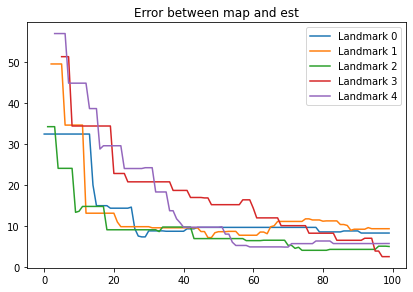

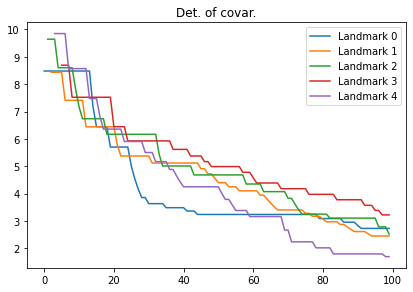

In [20]:
#mode = 'step_by_step'
mode = 'visualize_process'
#mode = 'non_stop'

# WORLD MAP
# Num features/landmarks considered within the map
nLandmarks = 5
# Generation of the map
MapSize = 100
Map = MapSize*random.rand(2,nLandmarks)-MapSize/2

# ROBOT
# Covariances for our very bad&expensive sensor (in the system <d,theta>)
Sigma_r = 8.0
Sigma_theta = 7*np.pi/180
# Initial robot pose
xVehicleTrue = np.vstack([-MapSize/1.5, -MapSize/1.5, 0.]) # We know the exact robot pose at any moment

robot = EFKMappingRobot(xVehicleTrue, Sigma_r, Sigma_theta, nLandmarks)

nSteps=100
logger = Logger(n_features=nLandmarks, n_steps=nSteps)

demo_ekf_mapping(robot,
                 Map,
                 nLandmarks,
                 logger=logger,
                 mode='non_stop',
                 nSteps=nSteps)

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Having taken a look at the logger and its output, you will be able to **answer the following questions**:

- What information is shown in the figures produced by the logger?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>El logaritmo del determinante de la matriz de coviarianza y el logaritmo del error/tiempo</i></p>
    
- The information about the error and the determinant of the covariance is provided for first time at different iterations of the algorithm for each landmark. Is that an error? Why is this happening?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>No es un error, estamos midiendo la distancia a la landmark con respecto al tiempo.</i></p>

- The error associated to each landmark not always decreases with new observations. Why could this happen?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Esto ocurre por la incertidumbre del sensor.</i></p>
    
- On the contrary, the determinant of the covariance matrix associated to each landmark always decreases when new observations are available. Is this an error? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La incertidumbre disminuye a medida que aumenta el número de observaciones</i></p>    